# Assingment 5 submission
 ### 1. Preprocessing
 ### 2. Epoching
 ### 3. P300 ERP
 ### 4. ICA
 
 Lets begin by importing some essentials:

In [1]:
import pyxdf
import PyQt5
import mne
import numpy as np
import pathlib
import mne
import matplotlib
import matplotlib.pyplot as plt
# For interactive plots
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'qt')
from subfunctions import read_xdf, add_annot

Lets load the XDF file

In [2]:
current_path = pathlib.Path().absolute()  
data_fname = current_path /'Data'/'P300_Gilad.xdf'

raw,events = read_xdf(fname = data_fname)
raw = add_annot(raw, events)

2 streams loaded
Creating RawArray with float64 data, n_channels=13, n_times=31405
    Range : 0 ... 31404 =      0.000 ...   251.232 secs
Ready.


And take a first look at our data

Using matplotlib as 2D backend.


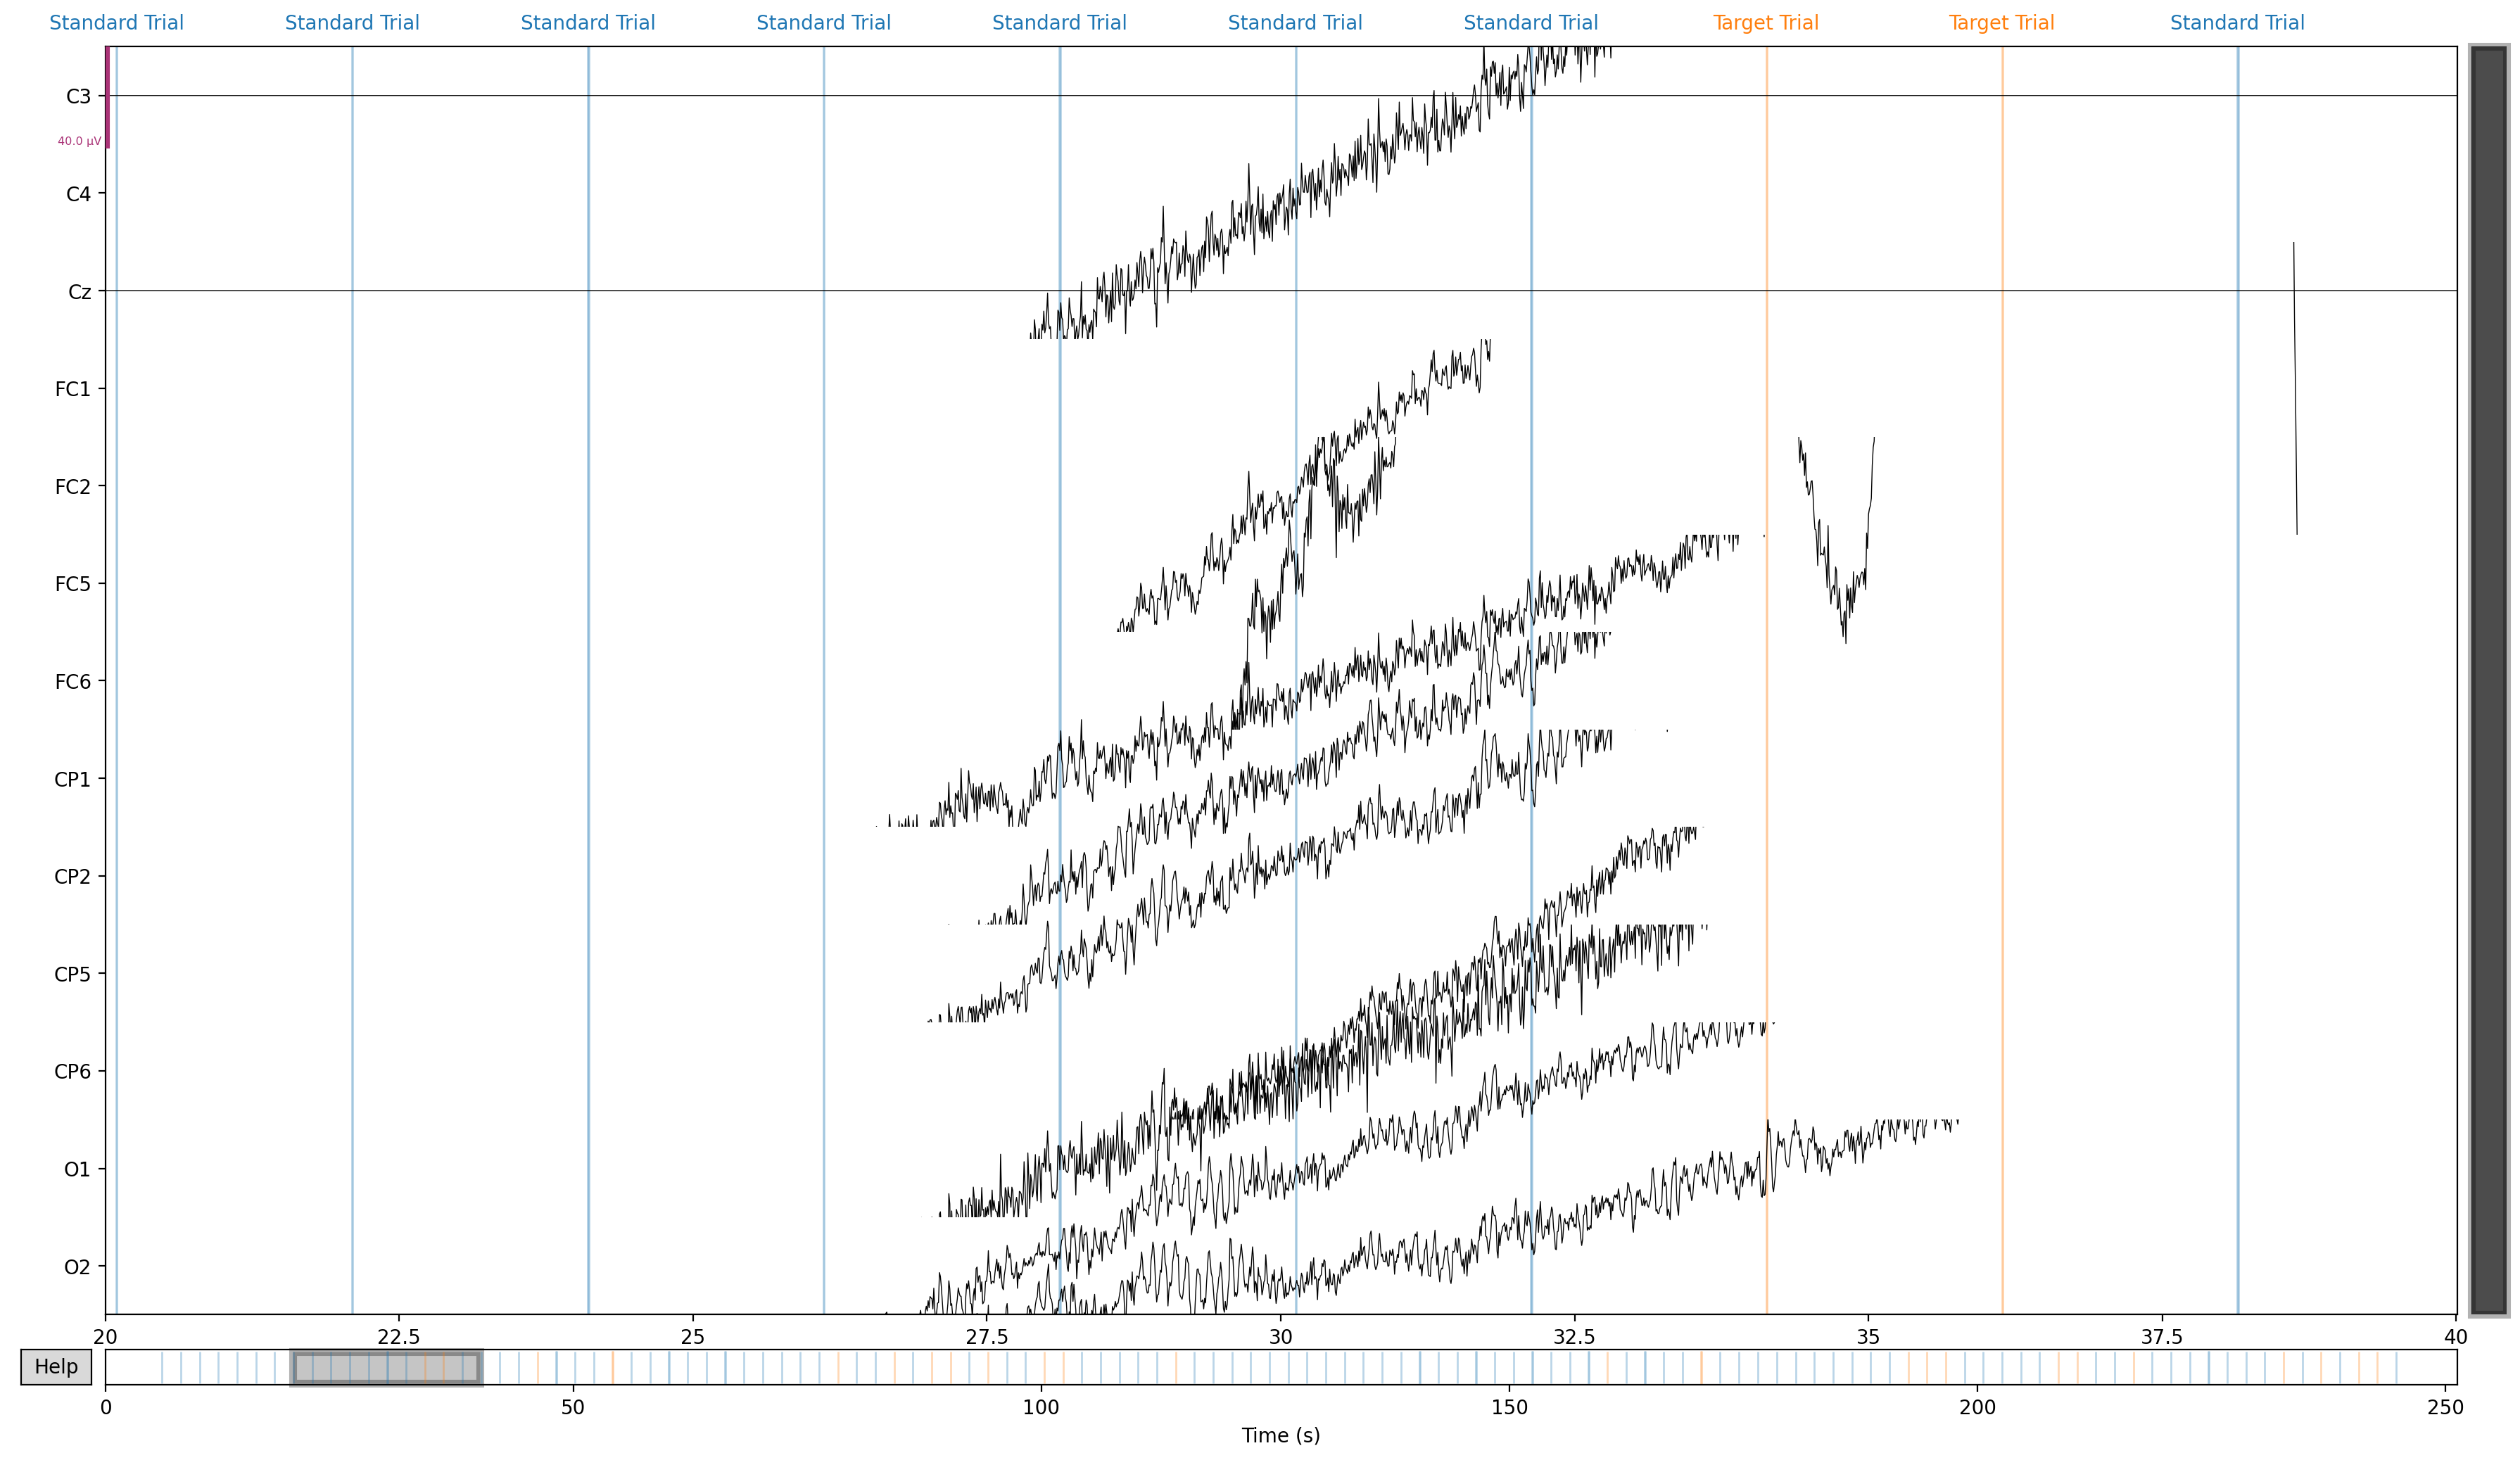

Channels marked as bad:
none


In [3]:
raw.plot(duration=20,start=20)

## Prepro

### 1. The drift is too extreme to enable ploting. We should apply highpass filter first

In [5]:
raw.filter(l_freq=0.5,h_freq=None)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Filter length: 825 samples (6.600 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished


<RawArray | 13 x 31405 (251.2 s), ~3.1 MB, data loaded>

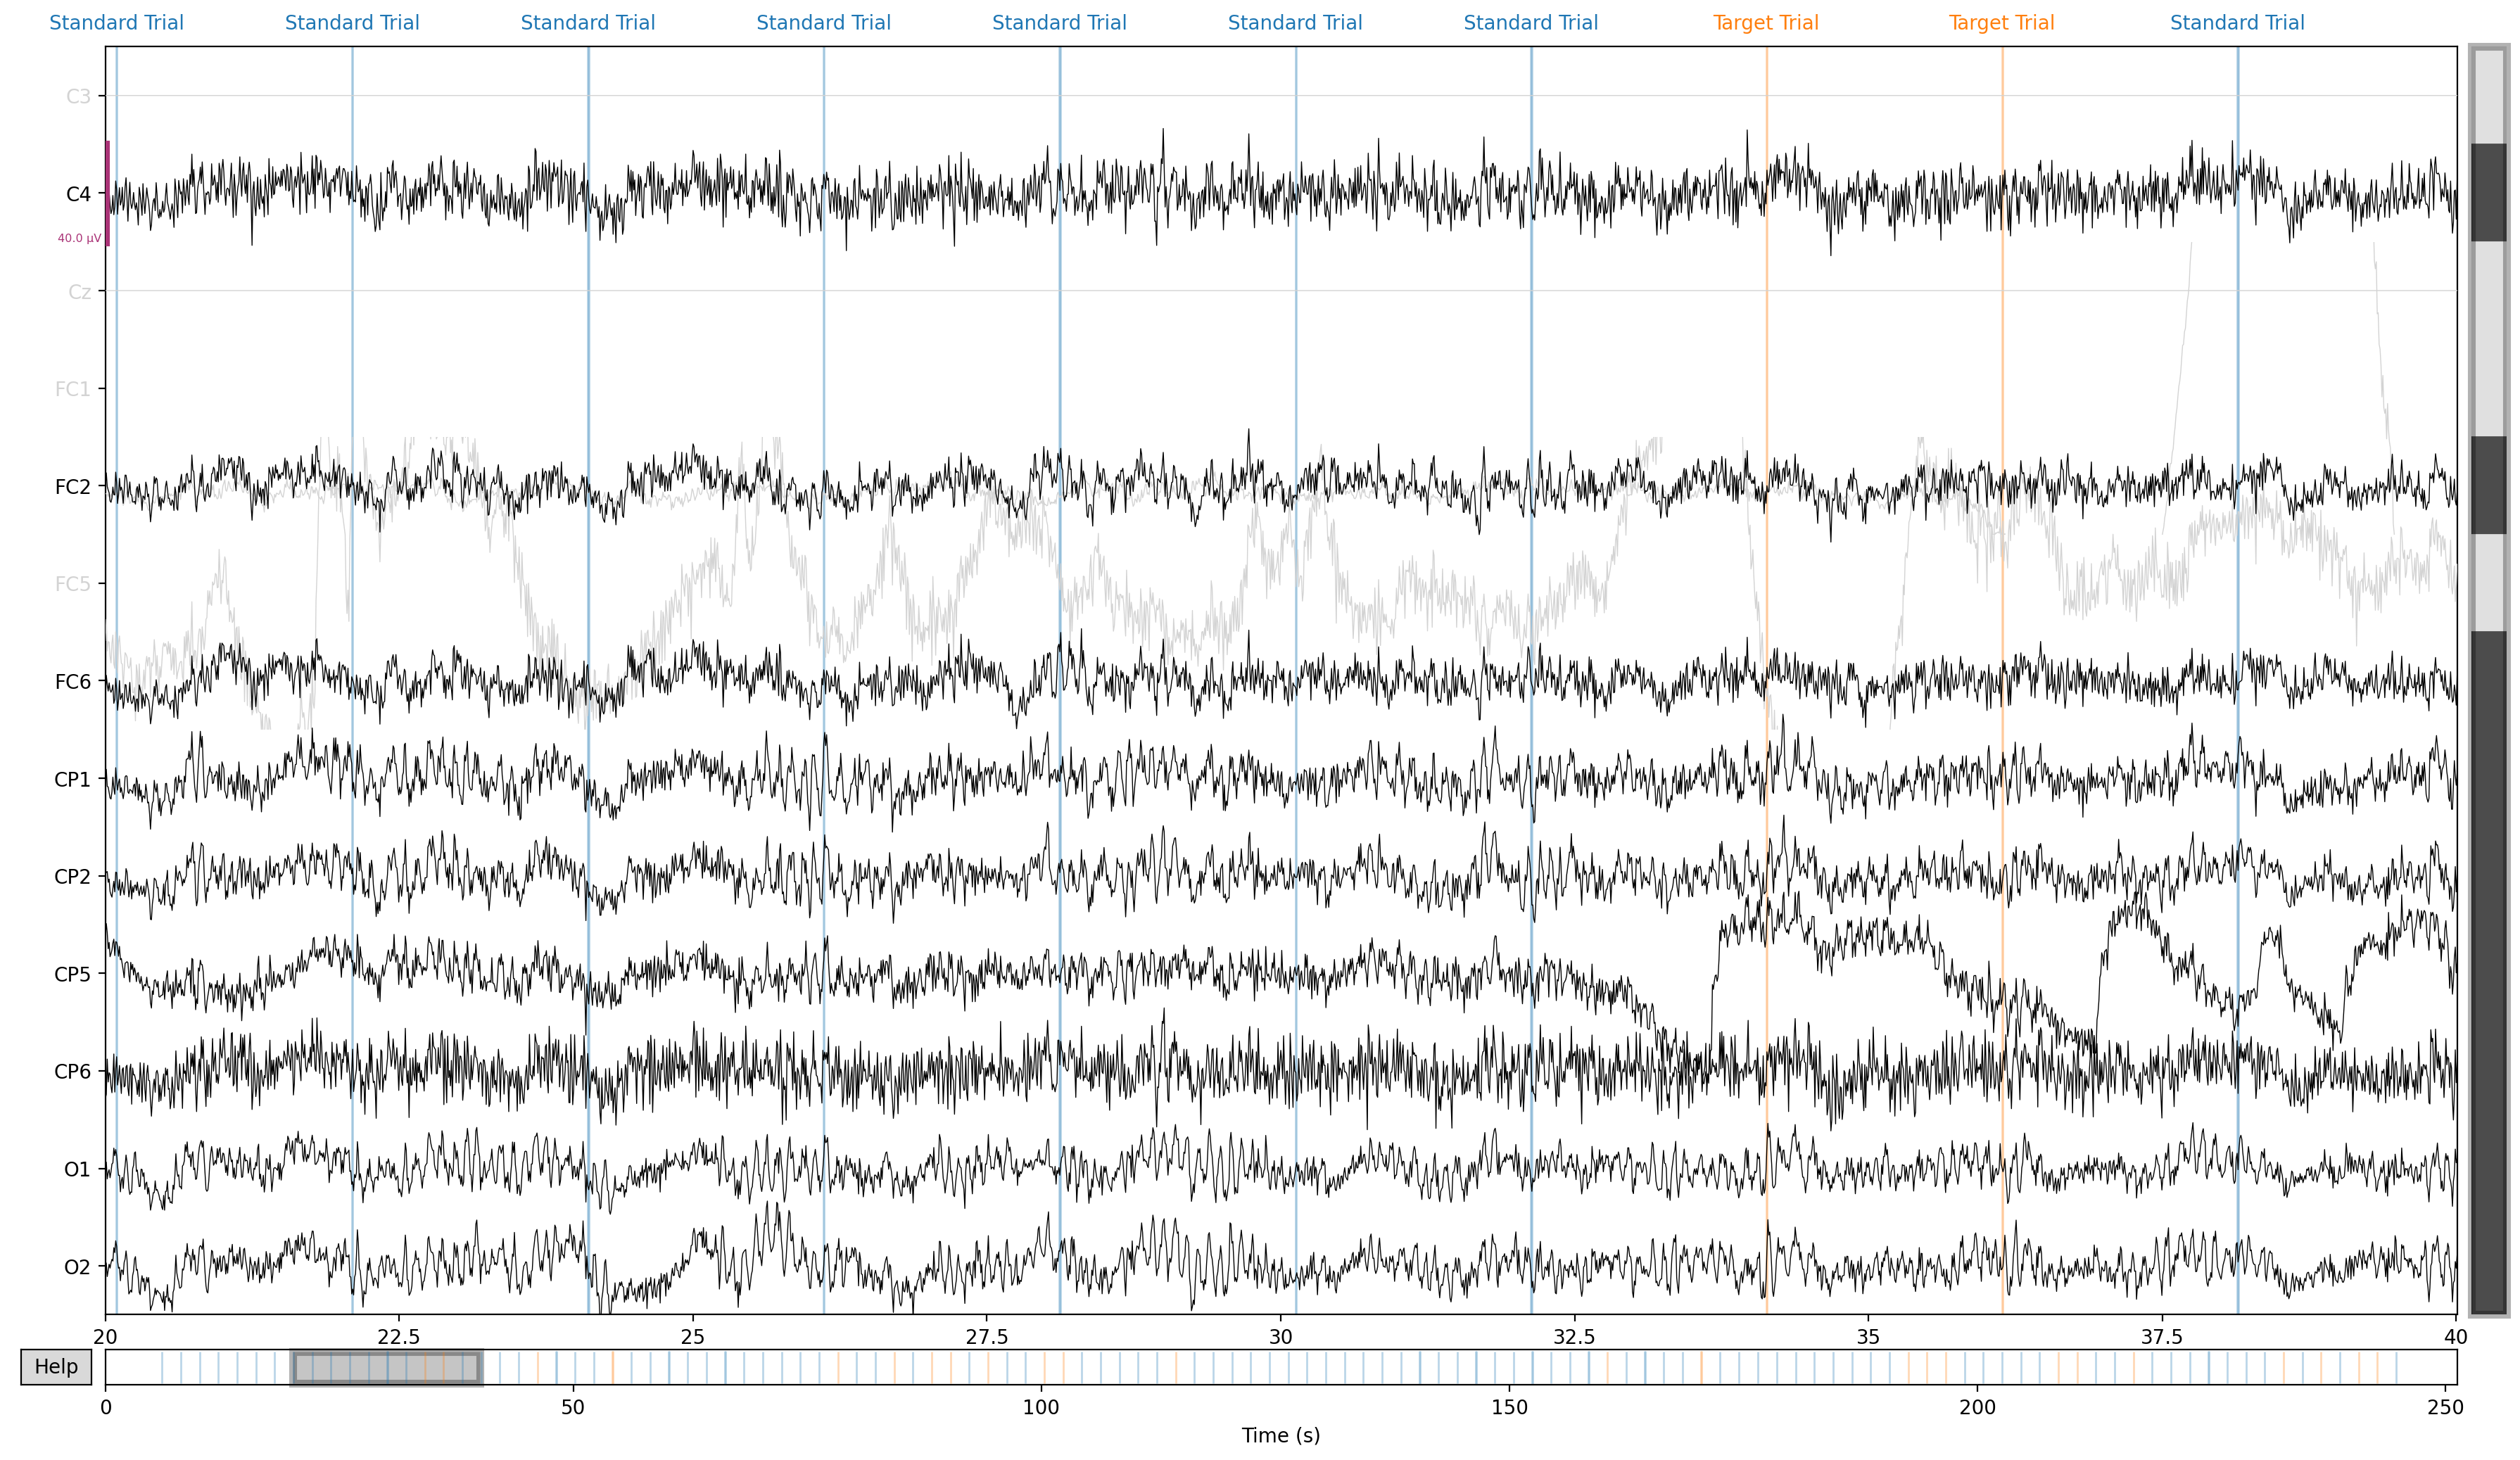

Channels marked as bad:
['Cz', 'C3', 'FC5', 'FC1']


In [6]:
raw.plot(duration=20,start=20)

That is way better, now we can see our data. It looks like there are a few bad electrodes - we should either remove or interpolate these electrodes before we continue 

In [7]:
original_raw = raw.copy() # save the original data for later comparison 
raw.drop_channels(raw.info['bads'])

<RawArray | 9 x 31405 (251.2 s), ~2.2 MB, data loaded>

Since we the data is sampled at 125Hz, there is no need to downsample or applay lowpass filter. But lets see if there is any line noise in our data

Effective window size : 2.048 (s)


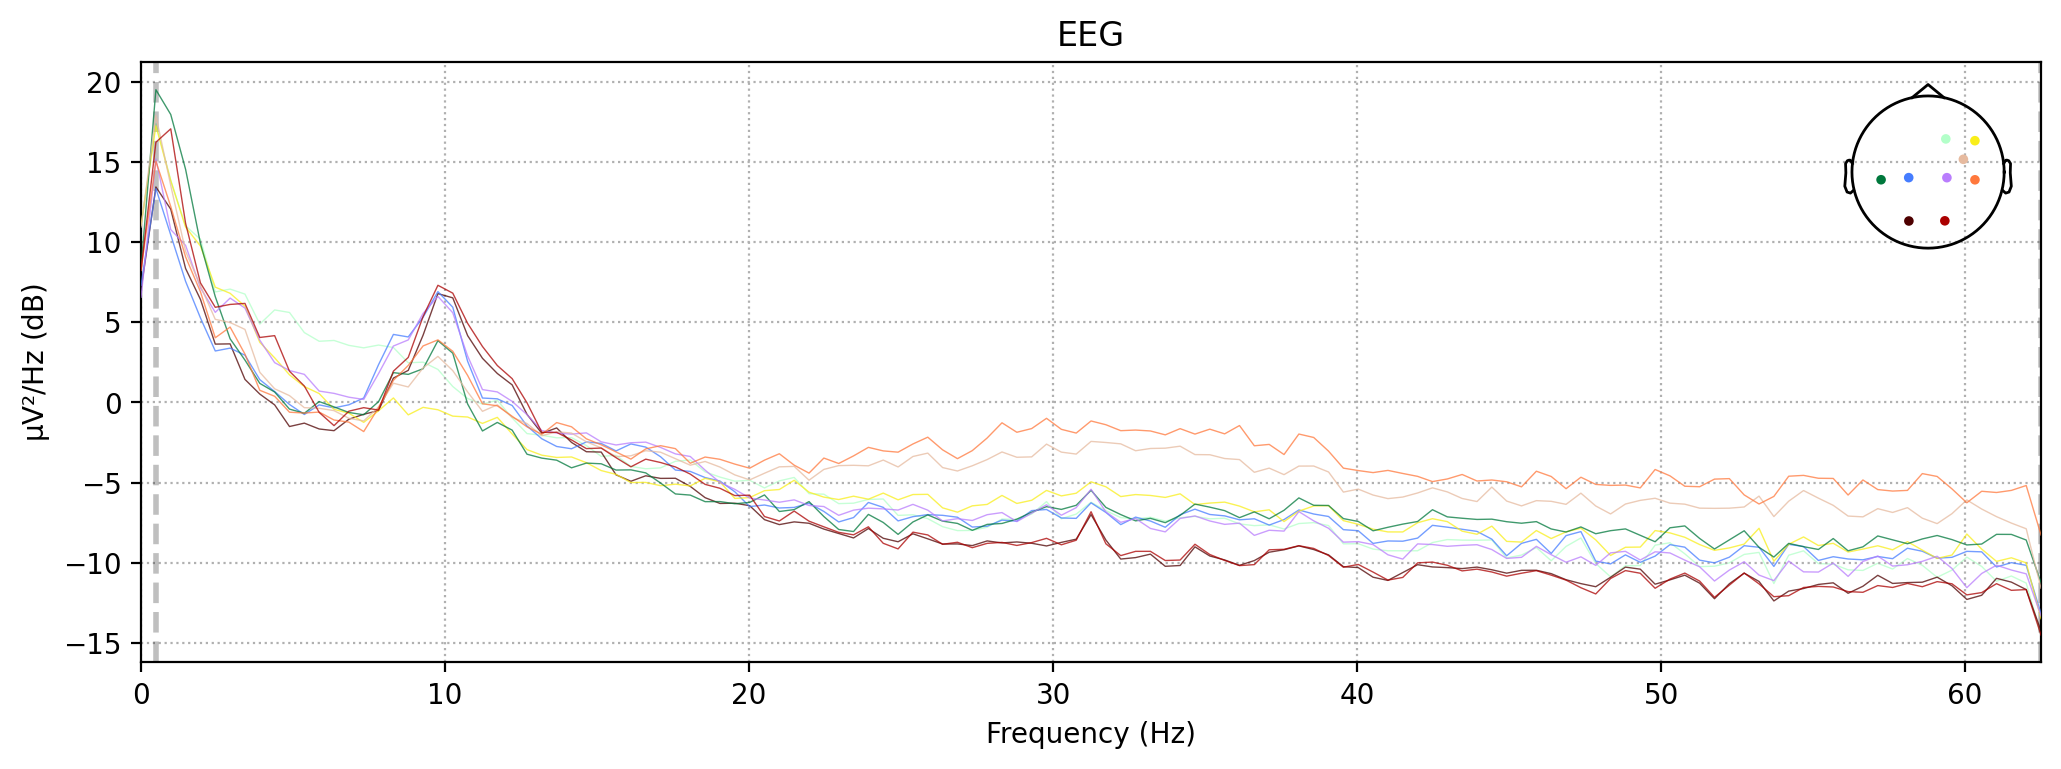

In [8]:
raw.compute_psd().plot()

No 50Hz peak, clear for epoching

## Epoching
### baseline correction by the 200 ms preceding the event 

In [9]:
events_from_annot, event_dict = mne.events_from_annotations(raw)
epochs = mne.Epochs(raw, events_from_annot, tmin=-0.2, tmax=0.6, event_id=event_dict,detrend=0,baseline= (-0.2,0))

Used Annotations descriptions: ['Standard Trial', 'Target Trial']
Not setting metadata
120 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


## Plot Epochs

### Lets see if there are any bad epochs to drop

Using data from preloaded Raw for 120 events and 101 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 10 events and 101 original time points ...


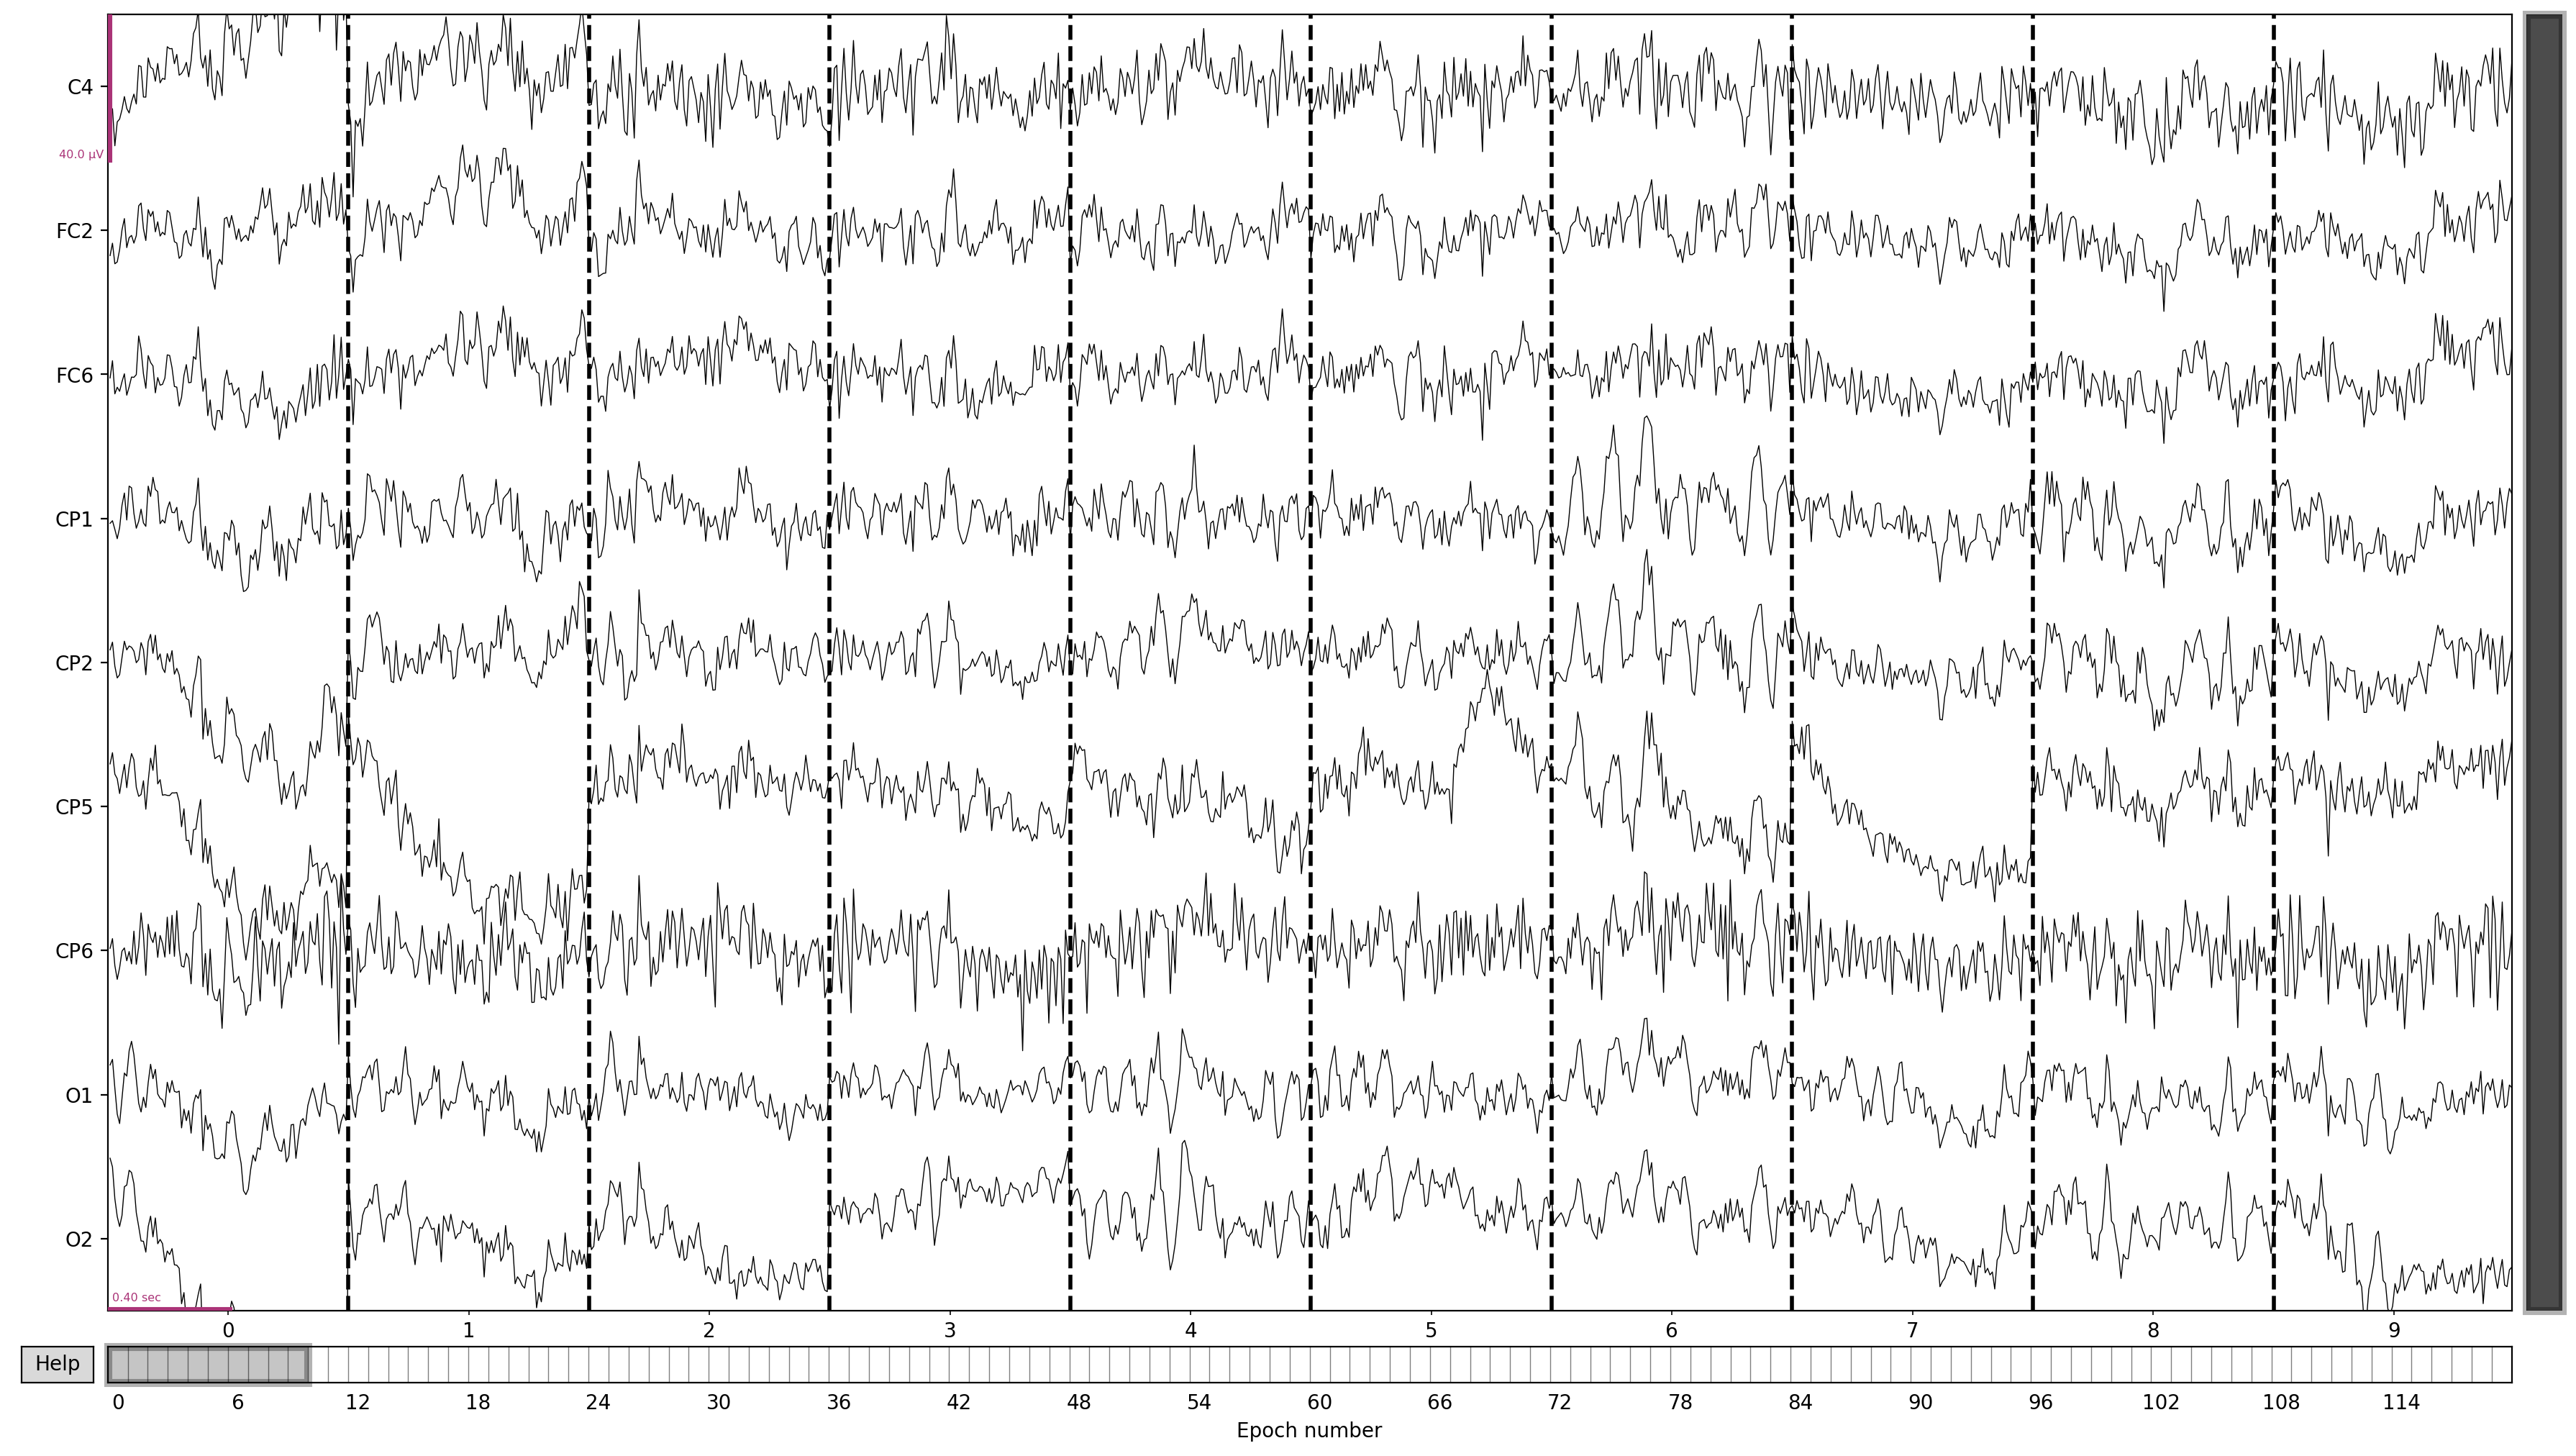

Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


In [10]:
epochs.plot(n_epochs=10)

Using data from preloaded Raw for 24 events and 101 original time points ...
Not setting metadata
24 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


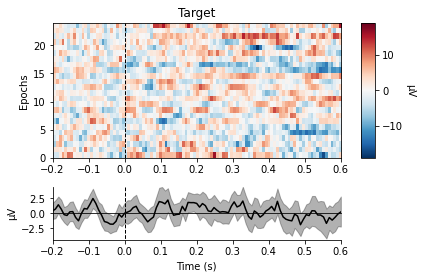

Using data from preloaded Raw for 96 events and 101 original time points ...
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


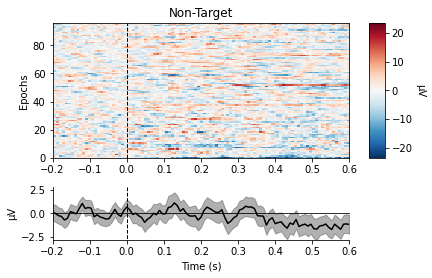

[<Figure size 432x288 with 3 Axes>]

In [19]:
get_ipython().run_line_magic('matplotlib', 'inline')

epochs['Target Trial'].plot_image(picks='eeg', combine='mean',title="Target")
epochs['Standard Trial'].plot_image(picks='eeg', combine='mean',title="Non-Target")


## Plot evoked data

No projector specified for this dataset. Please consider the method self.add_proj.


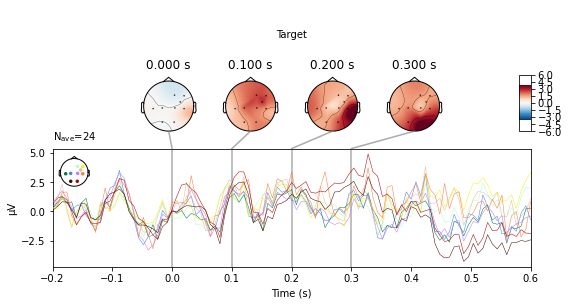

No projector specified for this dataset. Please consider the method self.add_proj.


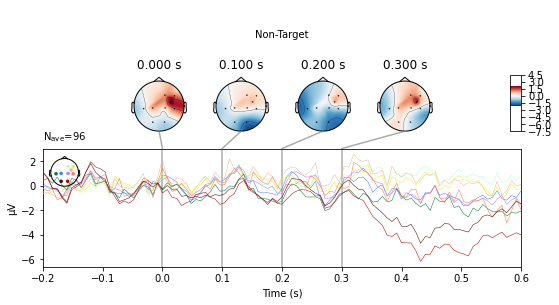

In [20]:
odd_evoked =  epochs['Target Trial'].average()
stand_evoked =  epochs['Standard Trial'].average()

par_picks = ['CP1','CP2'] # to plot only parietal



odd_evoked.plot_joint(picks='eeg',times=[0,0.1,0.2,0.3],title = 'Target')
stand_evoked.plot_joint(picks='eeg',times=[0,0.1,0.2,0.3],title = 'Non-Target')

plt.show()

## Lets compare the two ERPs

In [63]:
# For interactive plot:
get_ipython().run_line_magic('matplotlib', 'qt')

fig, ax = plt.subplots(4,figsize=(15, 20))


P300_window = [0.25,0.4]
par_picks = ['CP1','CP2'] # to plot only parietal


odd_evoked.plot(gfp=True,
    highlight=P300_window,axes=ax[0],titles='Target')

stand_evoked.plot(gfp=True,
    highlight=P300_window,axes=ax[1],titles='Non Target')

evokeds = dict(Non_Target=list(epochs['Standard Trial'].iter_evoked()),
               Target=list(epochs['Target Trial'].iter_evoked()))

mne.viz.plot_compare_evokeds(dict(Non_Target=stand_evoked, Target=odd_evoked),combine='mean',show_sensors= True,vlines= [0.3] ,axes=ax[2])

mne.viz.plot_compare_evokeds(evokeds, combine='mean',axes=ax[3])


plt.tight_layout()
#plt.show()

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


/var/folders/10/8b2yhzhd2c360q83nm9l57740000gn/T/ipykernel_85729/3830931353.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


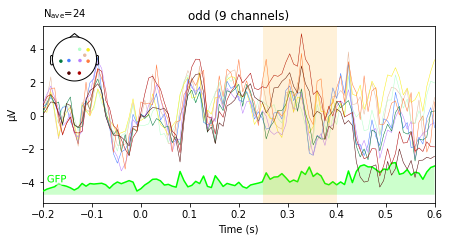

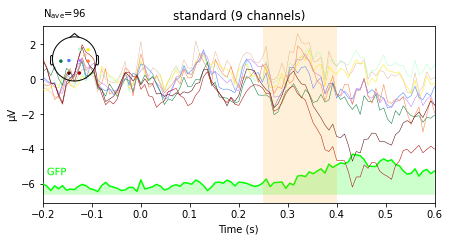

combining channels using "mean"
combining channels using "mean"


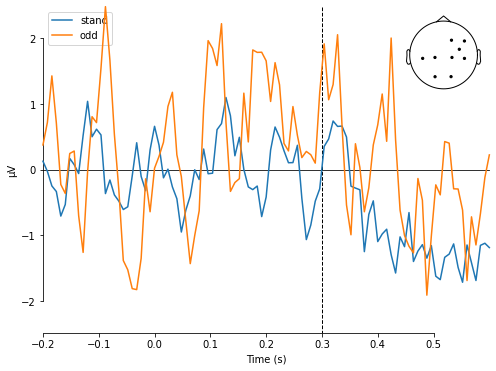

combining channels using "mean"
combining channels using "mean"


<Figure size 432x288 with 0 Axes>

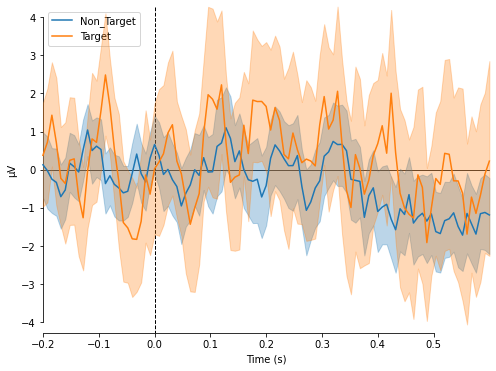

In [48]:
# Regular plots

get_ipython().run_line_magic('matplotlib', 'inline')


P300_window = [0.25,0.4]
par_picks = ['CP1','CP2'] # to plot only parietal


odd_evoked.plot(gfp=True,
    highlight=P300_window,titles='odd')

stand_evoked.plot(gfp=True,
    highlight=P300_window,titles='standard')

mne.viz.plot_compare_evokeds(dict(stand=stand_evoked, odd=odd_evoked),combine='mean',show_sensors= True,vlines= [0.3])


plt.tight_layout()


# We can also plot the CI of each ERP calss

evokeds = dict(Non_Target=list(epochs['Standard Trial'].iter_evoked()),
               Target=list(epochs['Target Trial'].iter_evoked()))
mne.viz.plot_compare_evokeds(evokeds, combine='mean')

get_ipython().run_line_magic('matplotlib', 'qt')

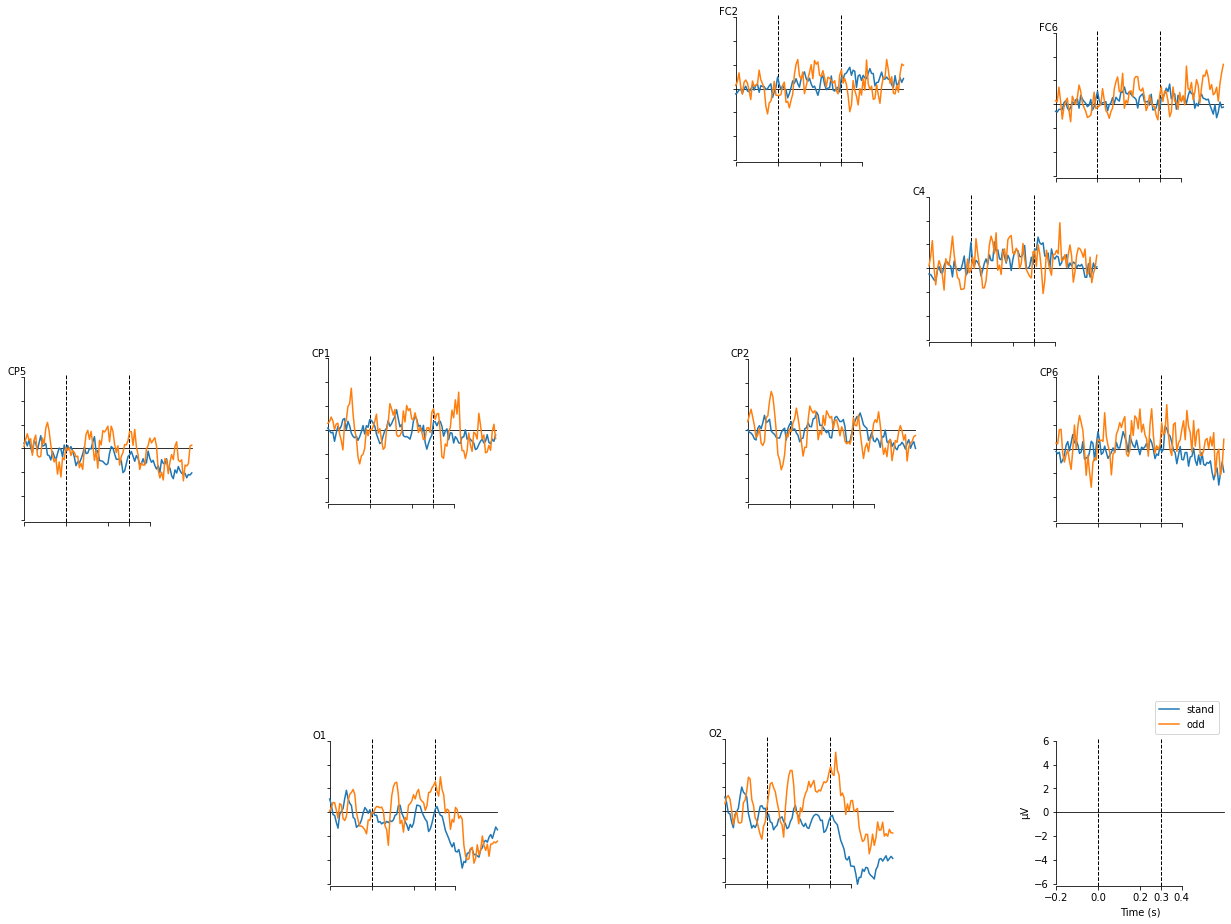

[<Figure size 1296x1008 with 10 Axes>]

In [52]:
# Each electrode indvidually 
get_ipython().run_line_magic('matplotlib', 'inline')
mne.viz.plot_compare_evokeds(dict(stand=stand_evoked, odd=odd_evoked),axes='topo',vlines=[0,0.3])

## ICA

In [53]:
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)

ica = ICA(n_components=raw.info['nchan'], max_iter='auto', random_state=97)
ica.fit(raw)
ica

Fitting ICA to data using 9 channels (please be patient, this may take a while)
Selecting by number: 9 components
Fitting ICA took 0.3s.


<ICA | raw data decomposition, method: fastica (fit in 32 iterations on 31405 samples), 9 ICA components (9 PCA components available), channel types: eeg, no sources marked for exclusion>

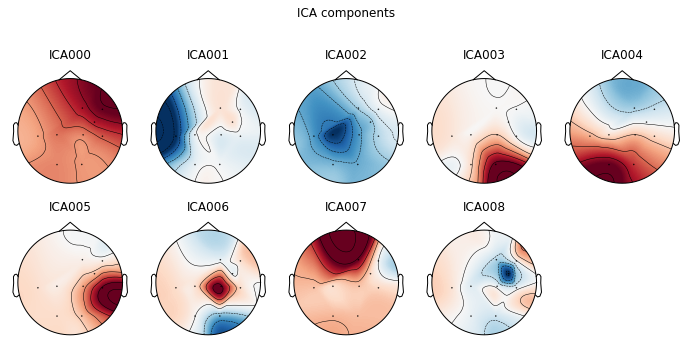

[<MNEFigure size 702x357.12 with 9 Axes>]

In [54]:
ica.plot_components()

Creating RawArray with float64 data, n_channels=9, n_times=31405
    Range : 0 ... 31404 =      0.000 ...   251.232 secs
Ready.


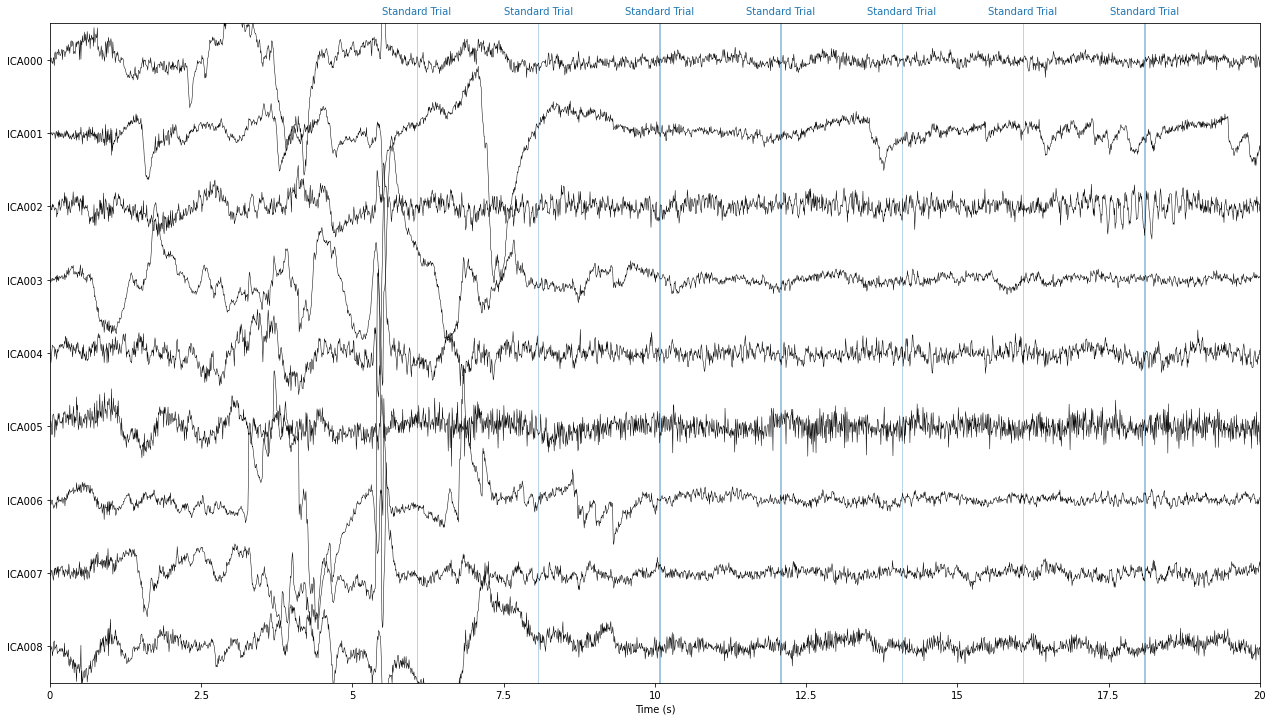

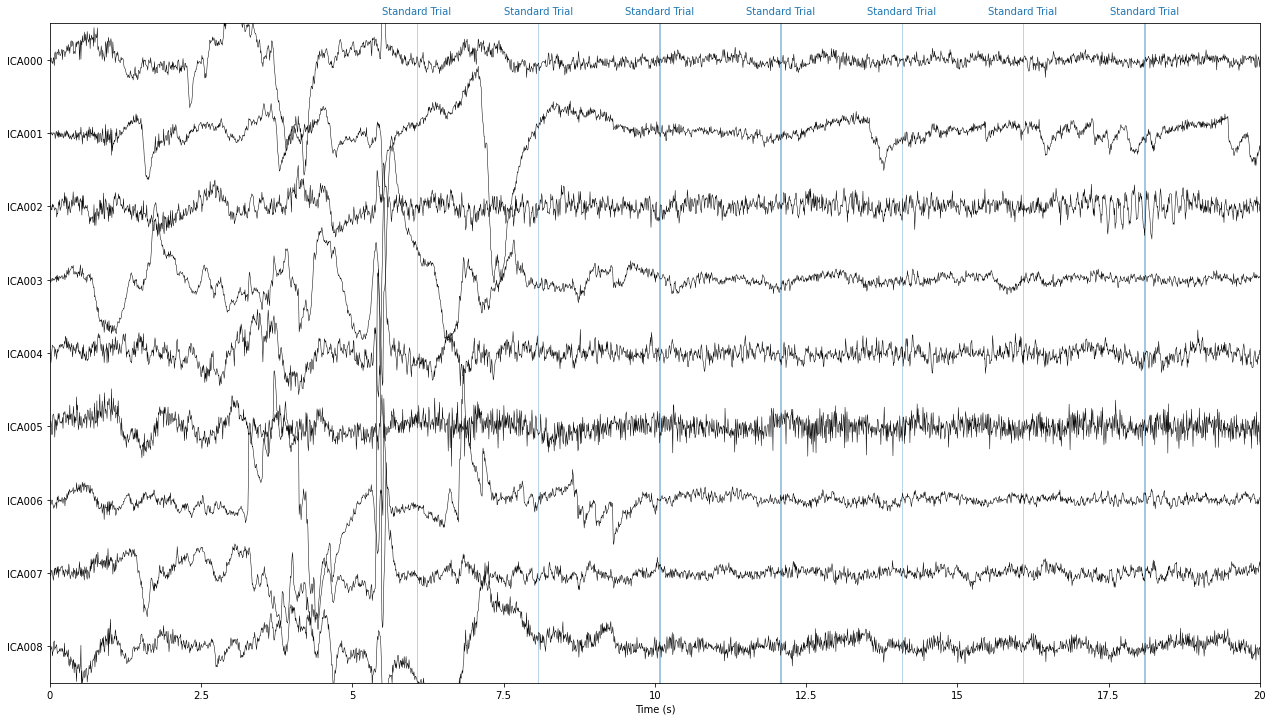

In [55]:
ica.plot_sources(raw, show_scrollbars=False)

Applying ICA to Raw instance
    Transforming to ICA space (9 components)
    Zeroing out 1 ICA component
    Projecting back using 9 PCA components


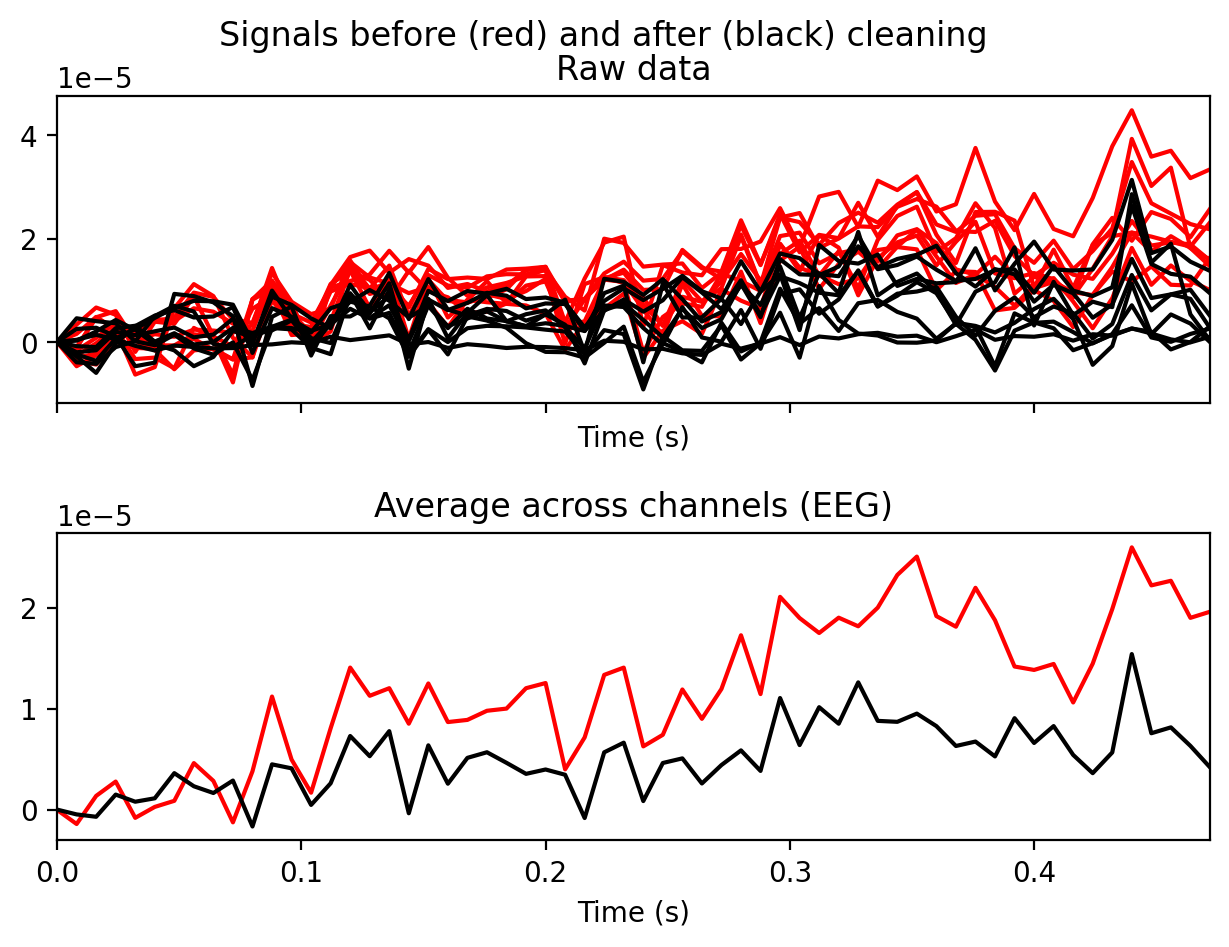

In [89]:
ica.plot_overlay(raw, exclude=[0], picks='eeg',start=0,stop=60)

# The first element looks like drift

Applying ICA to Raw instance
    Transforming to ICA space (9 components)
    Zeroing out 3 ICA components
    Projecting back using 9 PCA components


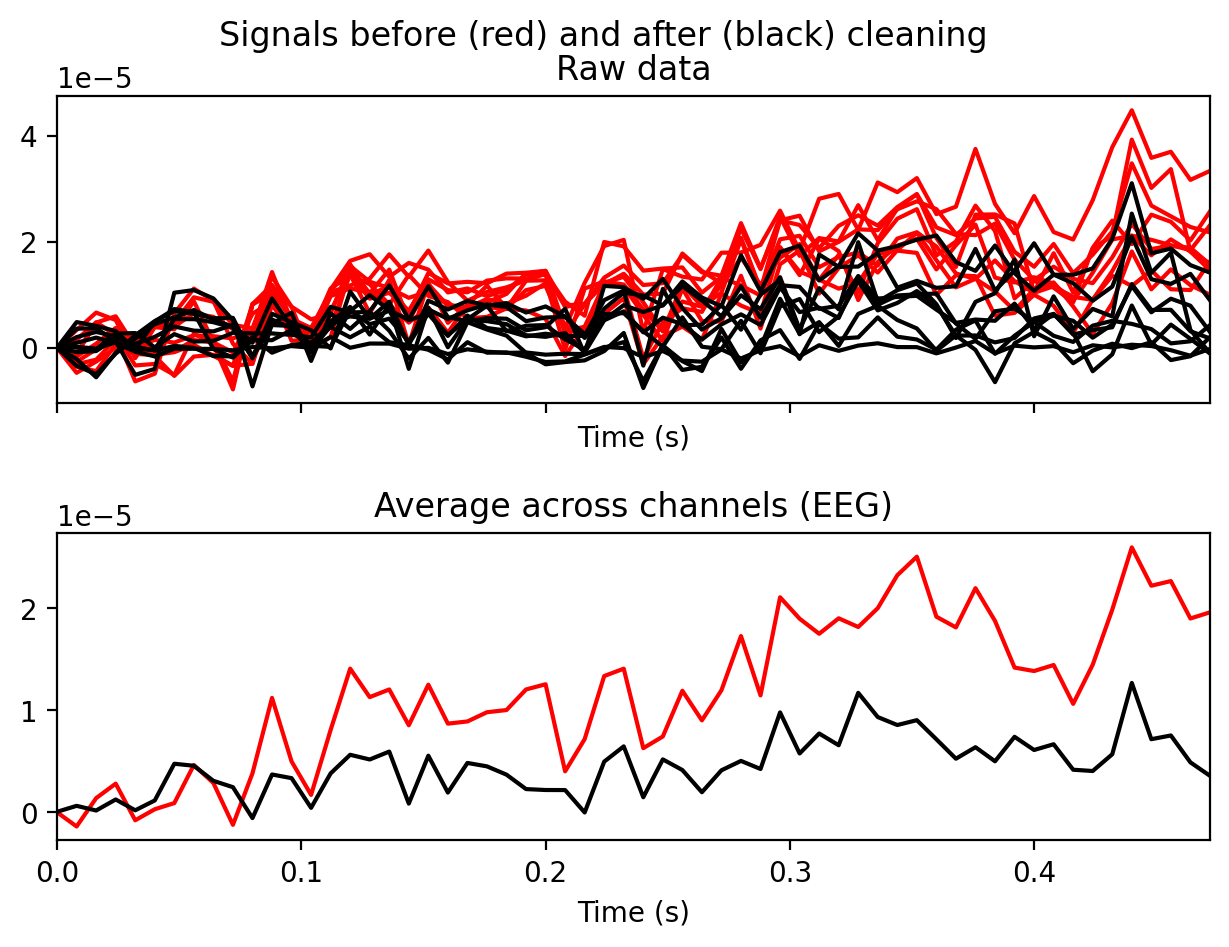

In [97]:
# None will show the selected componenets 
ica.plot_overlay(raw, exclude=[7], picks='eeg',start=0,stop=60)


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
125 matching events found
No baseline correction applied
0 projection items activated


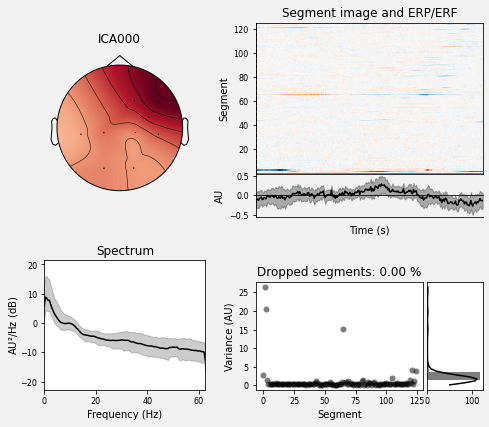

[<Figure size 504x432 with 6 Axes>]

In [62]:
ica.plot_properties(raw, picks=[0])

## Finally, lets applay the ICA and reconstruct the sensor data 

In [98]:
reconst_raw = raw.copy()
ica.apply(reconst_raw)

Applying ICA to Raw instance
    Transforming to ICA space (9 components)
    Zeroing out 3 ICA components
    Projecting back using 9 PCA components


<RawArray | 9 x 31405 (251.2 s), ~2.2 MB, data loaded>

## Lets look at the differences

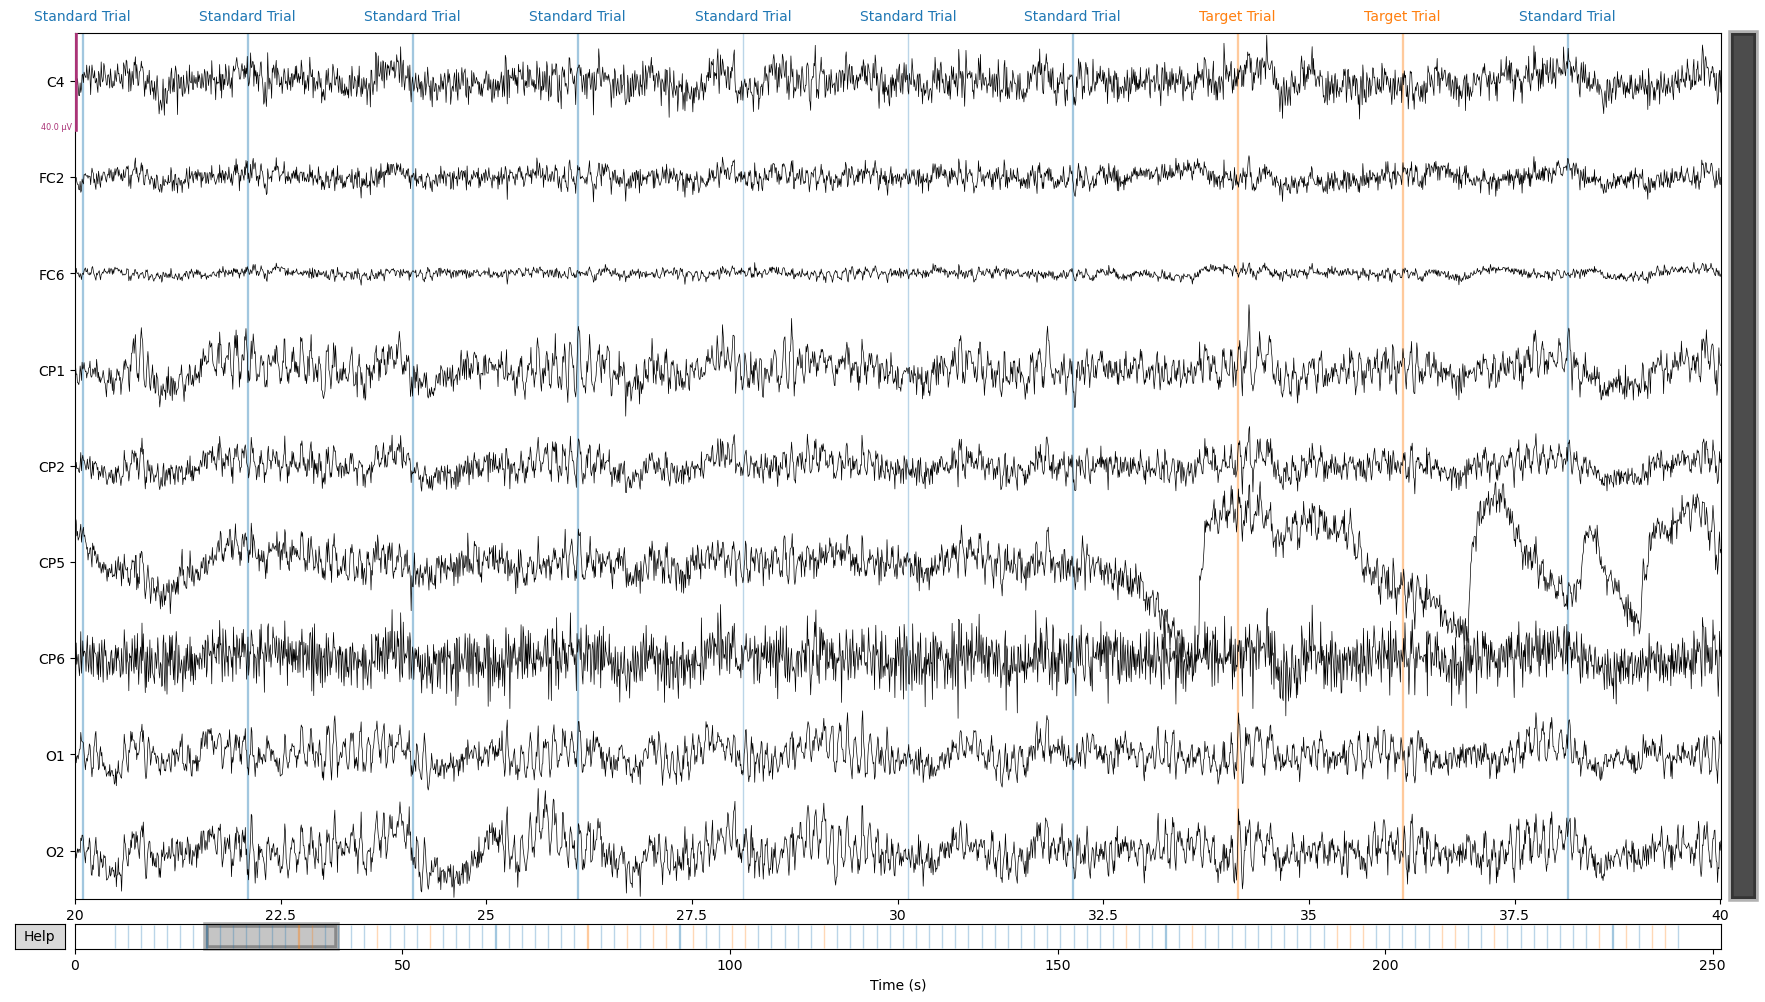

In [104]:
reconst_raw.plot(duration=20,start=20,show= False)

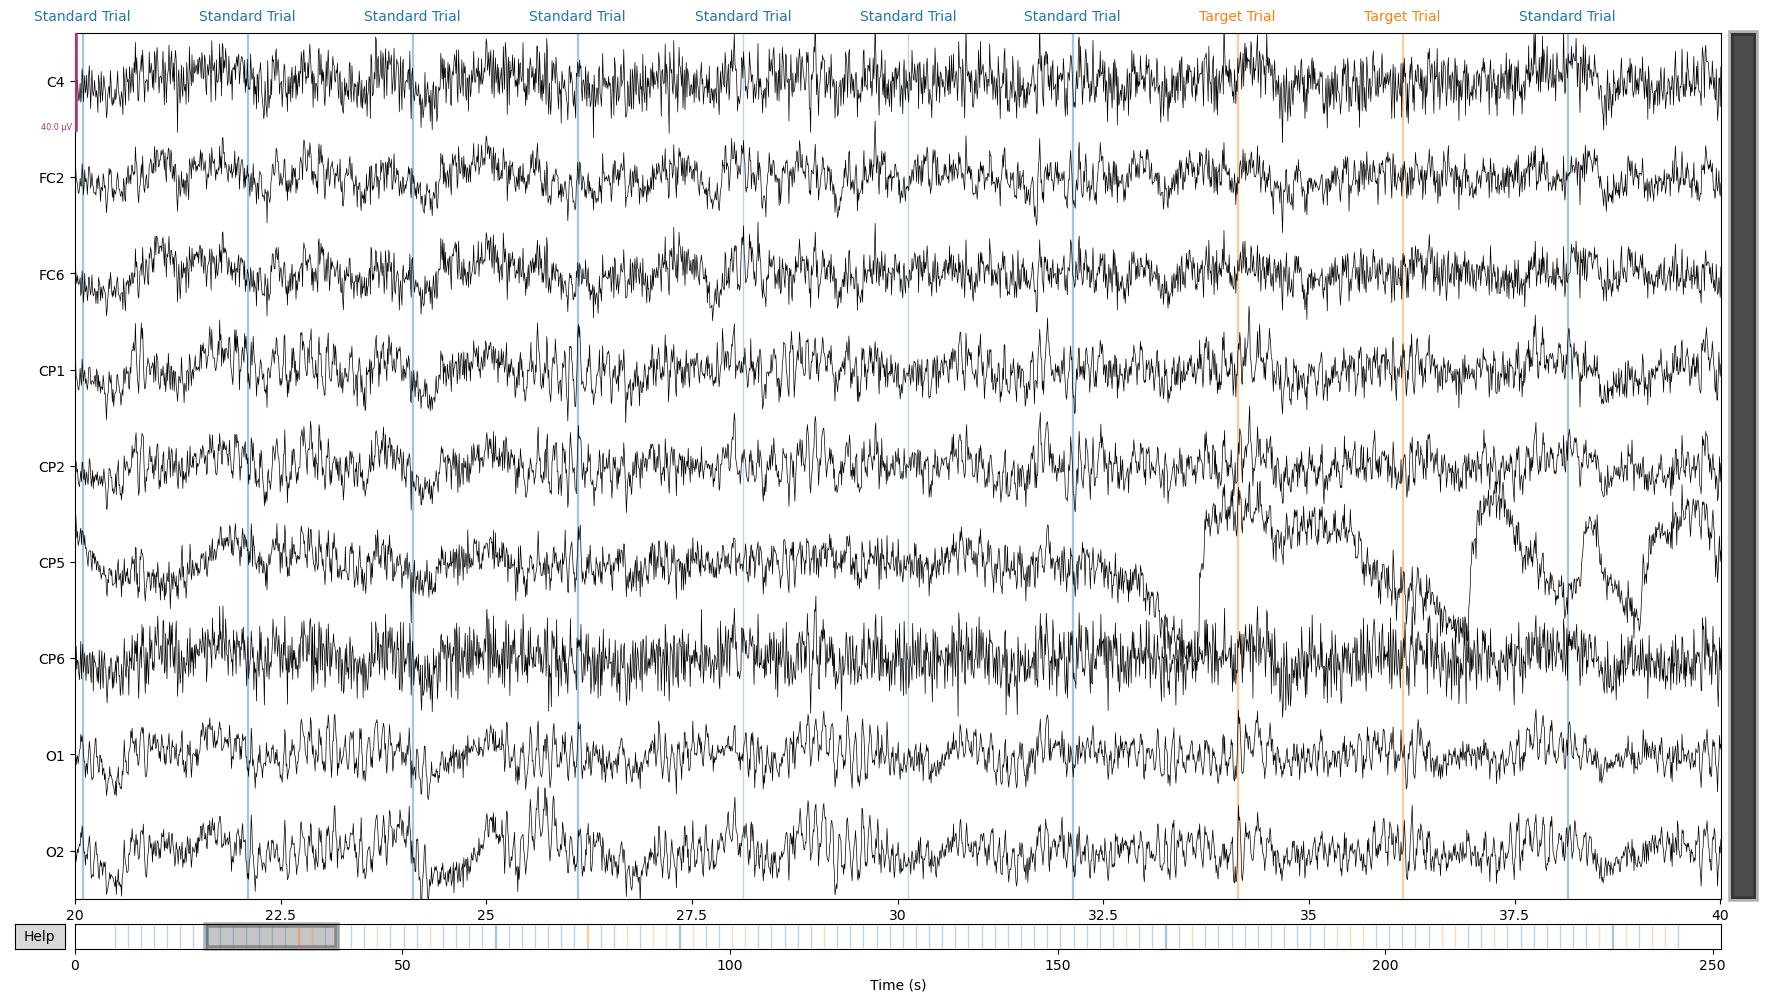

In [107]:
original_raw.plot(duration=20,start=20,show= False)
